**ABSTRACT**

Let's begin by installing our dependecies for our project. For this project, one of the main libraries we will be using is lightkurve which is a library created by NASA scientists to evaulate light curves as an exoplanet goes in front of its star. Our main purpose for this project is to be able to detect exoplanets using light anomalies

In [49]:
!pip install lightkurve
!pip install numpy
from lightkurve import search_targetpixelfile, TessTargetPixelFile
import numpy as np

Let's initialize our pixelfile as an object by searching for out target. Our target is going to be KIC 6922244 which is the Kepler-8b system. We are using this system as our reference point for our pixels. The star has similar characteristics to the Sun but has completely different behaviors. KIC stands for the Kepler Input Catalog which means that this is part of the Kepler telescope's findings.

<Axes: title={'center': 'Target ID: 6922244, Cadence: 11958'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

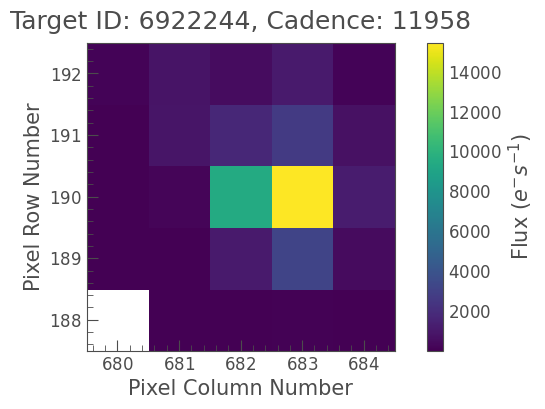

In [50]:
pixelfile = search_targetpixelfile("KIC 6922244", author="Kepler", cadence="long",quarter = 4).download()
pixelfile.plot(frame=42)

Now we are combining our individual frames into a lightcurve which will better allow us to see flux data day by day. We are also going to use an aperture mask so that we can analyze our image data more clearly.

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

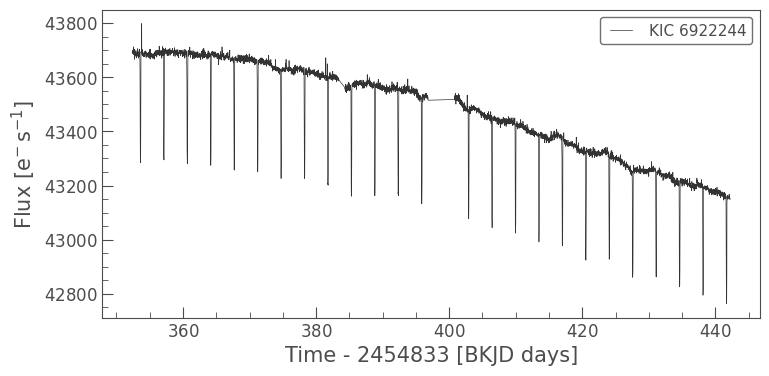

In [51]:
lc = pixelfile.to_lightcurve(aperture_mask = pixelfile.pipeline_mask)
lc.plot()

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

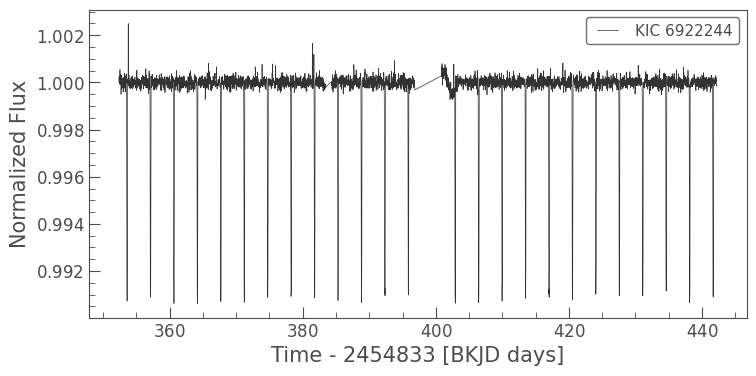

In [52]:
#Patterns are easier to spot when flattening the curve
flat_lc = lc.flatten()
flat_lc.plot()

The dips that we observe in flux are everytime that the exoplanet revolves in front of the star of the system. This is due to the reduction of light when its position is right in front of the light source.

<Axes: xlabel='Phase [JD]', ylabel='Normalized Flux'>

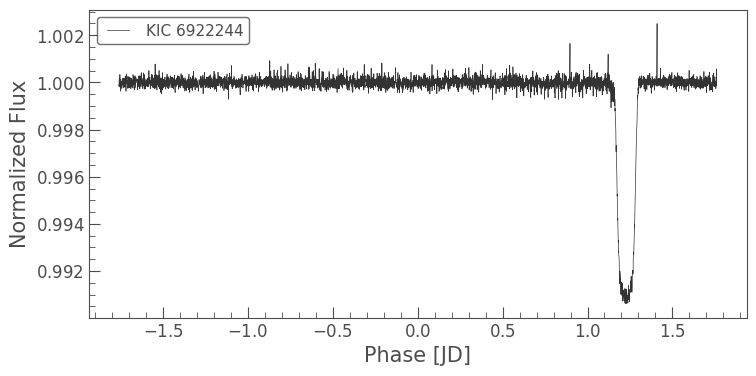

In [53]:
#We now have to fold the curve to see if the period and transit timings correspond to transit signals
#This will basically fold these patterns on top of each other making it easier to analyze
folded_lc = flat_lc.fold(period=3.5225)
folded_lc.plot()


This folded graph shows us the motion of our "exoplanet" in the form of differences in flux levels as the planet moves around the star. But, we also need a way to measure how long this periodic movement actually lasts to observe whether this moving object is actually an exoplanet or not. This is achieved through something known as a periodogram. A periodogram shows you all repetitive patterns in your graph and shows you which pattern is most likely an orbital period. Periodograms are an estimate of the spectral density of a signal.

<Axes: xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

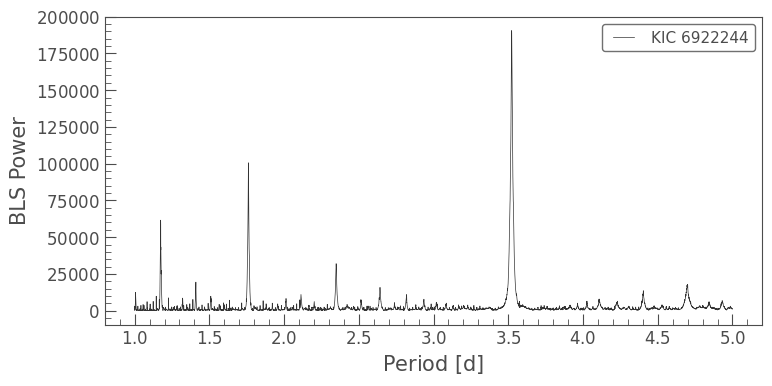

In [54]:
#bls refers to the box least squares method
period = np.linspace(1,5,10000)
bls = lc.to_periodogram(method = 'bls', period = period, frequency_factor = 500)
bls.plot()

In [60]:
#Lets store this most prominent pattern spike in a variable
planet_x_period = bls.period_at_max_power
planet_x_t0 = bls.transit_time_at_max_power
planet_x_dur = bls.duration_at_max_power
print("Period: ",planet_x_period)
print("Transit Time: ",planet_x_t0)
print("Duration: ",planet_x_dur)

Period:  3.522652265226523 d
Transit Time:  353.60132485035285
Duration:  0.1 d


(-2.0, 2.0)

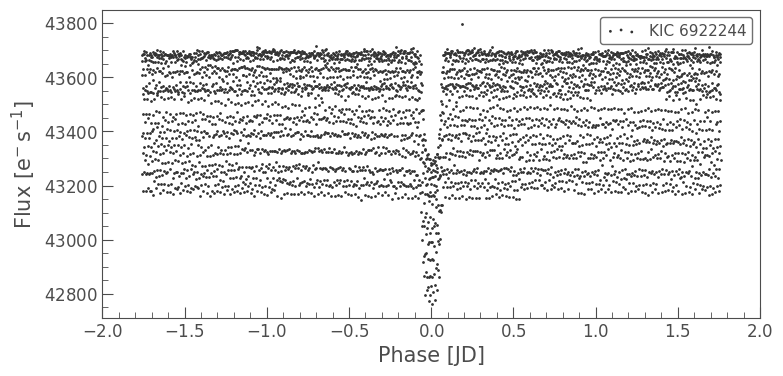

In [61]:
ax = lc.fold(period=planet_x_period, epoch_time=planet_x_t0).scatter()
ax.set_xlim(-2,2)

Since this was just an example to test lightcurves. Let's try to pick our own star to analyze!

In [69]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

def download_and_unzip(url, extract_to='.'):
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)

product_group_id = '62337089'
url = 'https://mast.stsci.edu/api/v0.1/Download/bundle.zip?previews=false&obsid=' + product_group_id
destination = '/TESS/'

download_and_unzip(url, destination)


<Axes: title={'center': 'Target ID: 366483817, Cadence: 190249'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

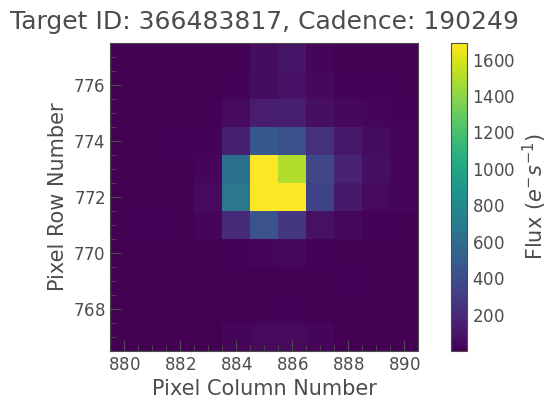

In [70]:
#/TESS/MAST_2024-06-17T0434/TESS/tess2019006130736-s0007-0000000366483817-0131-s/tess2019006130736-s0007-0000000366483817-0131-s_tp.fits
tpf = TessTargetPixelFile("/TESS/MAST_2024-06-17T0434/TESS/tess2019006130736-s0007-0000000366483817-0131-s/tess2019006130736-s0007-0000000366483817-0131-s_tp.fits")
# Show a single snapshot
tpf.plot(frame=42)



<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

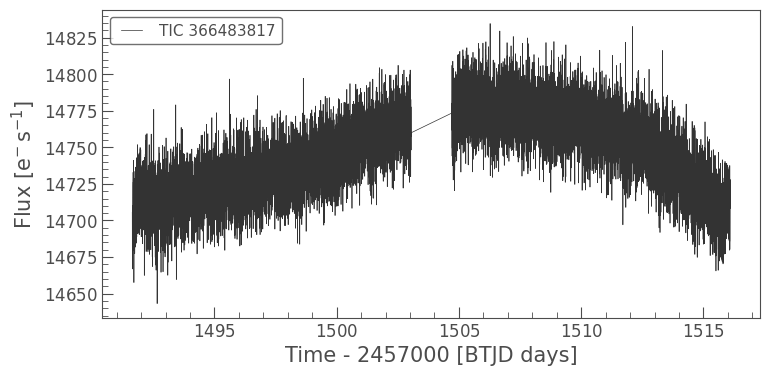

In [71]:
# Plot the lightcurve
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
lc.plot()



<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

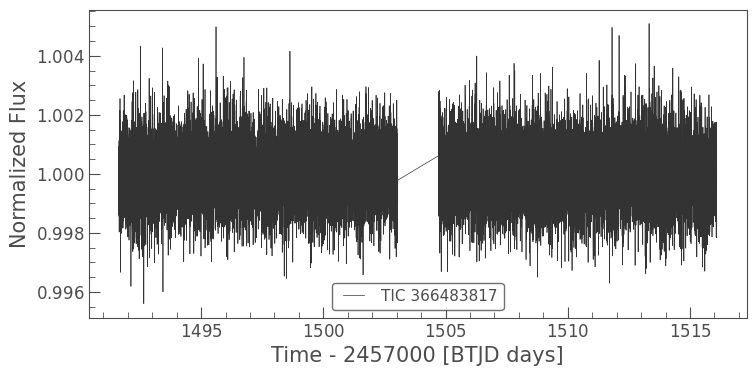

In [72]:
# Flatten it
flat_lc = lc.flatten()
flat_lc.plot()



(-3.0, 3.0)

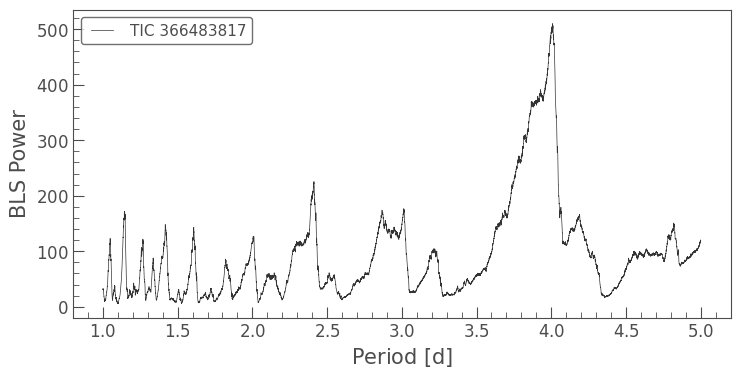

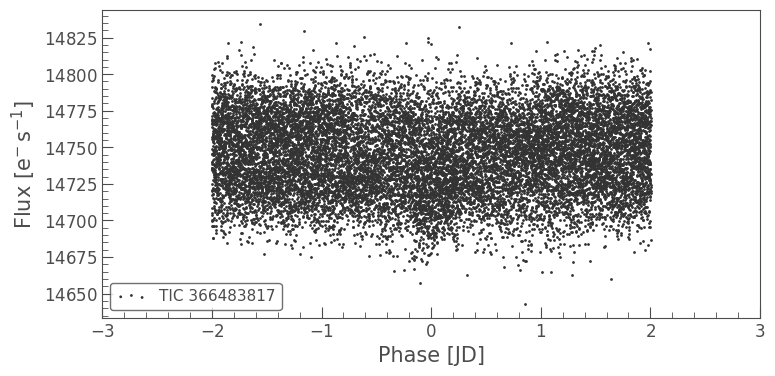

In [73]:
# Try and find the period of the most prominent orbiting object
period = np.linspace(1, 5, 10000)
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500)
bls.plot()

planet_x_period = bls.period_at_max_power
planet_x_t0 = bls.transit_time_at_max_power
planet_x_dur = bls.duration_at_max_power

# Phase-fold the ligthcurve based on the discovered period at max power
ax = lc.fold(period=planet_x_period, epoch_time=planet_x_t0).scatter()
ax.set_xlim(-3,3)